In [1]:
import torch
import pandas as pd
import numpy as np
import joblib
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score,f1_score,ConfusionMatrixDisplay,confusion_matrix,accuracy_score,classification_report
from sklearn.svm import SVC
import torch.optim as optim
from sklearn.model_selection import GridSearchCV


def get_result(y_test,pred):
    print('Acc',accuracy_score(y_test,pred))
    print('f1',f1_score(y_test,pred))
    print('precision',precision_score(y_test,pred))

# Training steps

In [2]:
df = pd.read_csv('dataset/bank-full.csv',sep=';')
df_train,df_test = train_test_split(df, test_size=0.20, random_state=42)
# df_test.to_csv('test.csv',index=False)

X_train = df_train.drop('y',axis=1)
y_train = df_train['y']
y_train = y_train.replace(['yes','no'],[1,0])
X_train.drop('poutcome',axis=1,inplace=True)

In [3]:
y_train.value_counts(normalize=True)

0    0.883931
1    0.116069
Name: y, dtype: float64

In [4]:
X_train.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
dtype: int64

In [5]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous
3344,41,blue-collar,married,primary,no,849,yes,no,unknown,15,may,72,1,-1,0
17965,49,technician,married,primary,no,1415,yes,no,cellular,30,jul,269,2,-1,0
18299,42,admin.,married,secondary,no,3842,no,no,cellular,31,jul,130,4,-1,0
10221,37,management,single,tertiary,no,-119,yes,no,unknown,11,jun,375,11,-1,0
32192,56,blue-collar,married,primary,no,3498,no,no,cellular,15,apr,264,2,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,housemaid,single,primary,no,1059,no,no,unknown,18,jun,2093,1,-1,0
44732,23,student,single,tertiary,no,508,no,no,cellular,8,sep,210,1,92,1
38158,34,technician,divorced,tertiary,no,1317,yes,no,cellular,15,may,239,1,-1,0
860,33,retired,married,secondary,no,165,no,no,unknown,7,may,111,1,-1,0


In [6]:
categorical_cols = list(set(X_train.select_dtypes('O')))
numeric_cols = list(set(X_train) - set(X_train.select_dtypes('O')))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train = preprocessor.fit_transform(X_train)

In [7]:
# save preprocessor
joblib.dump(preprocessor, "saved_model/preprocessor.pkl") 

['saved_model/preprocessor.pkl']

In [8]:
up_sample = SMOTE(random_state=42)
down_sample = RandomUnderSampler(random_state=42)

X_train_up, y_train_up = up_sample.fit_resample(X_train,y_train)
X_train_down, y_train_down = down_sample.fit_resample(X_train,y_train)

# SVM Training and model save
- on actual, upsampled and downsampled

In [9]:
def exp_svc(k):
    for title, (train_x,train_y) in zip(['imbalanced','upsampled','downsampled'],[(X_train,y_train),(X_train_up,y_train_up), (X_train_down,y_train_down)]):
        svc_clf = SVC(kernel=k,random_state = 0)
        svc_clf.fit(train_x,train_y)
        
        # save
        joblib.dump(svc_clf, f"SVM_{title}_{k}.pkl") 
        pred_svc = svc_clf.predict(X_test)
        cm = confusion_matrix(y_test, pred_svc, labels=svc_clf.classes_)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
        disp.plot(values_format=".2f")
        plt.title(title)
        plt.show()
        get_result(y_test,pred_svc)

In [10]:
# test
df_test = pd.read_csv('dataset/test.csv',sep=',')
df_test.drop('poutcome',axis=1,inplace=True)
X_test = df_test.drop('y',axis=1)
y_test = df_test['y']
y_test = y_test.replace(['yes','no'],[1,0])

X_test = preprocessor.transform(X_test)

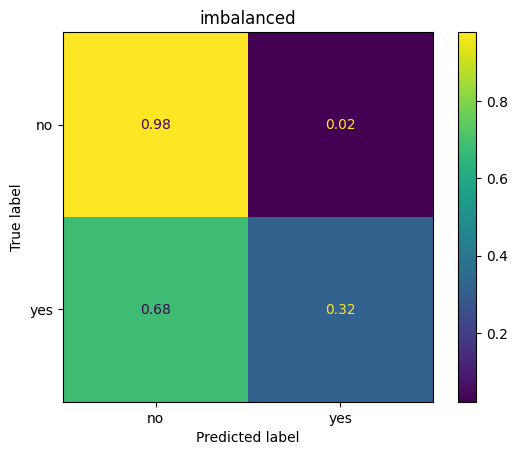

Acc 0.8983744332632976
f1 0.4309597523219814
precision 0.6641221374045801


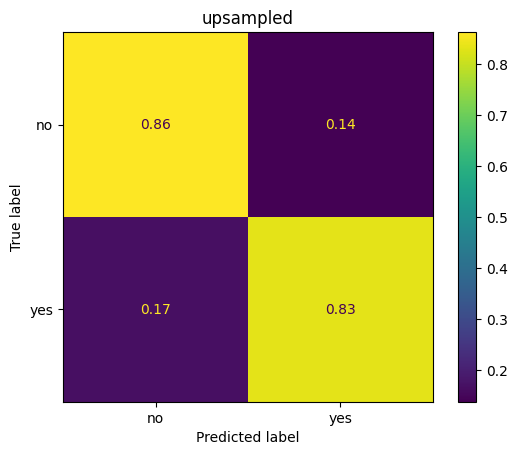

Acc 0.8587858011721774
f1 0.5873990306946688
precision 0.4535928143712575


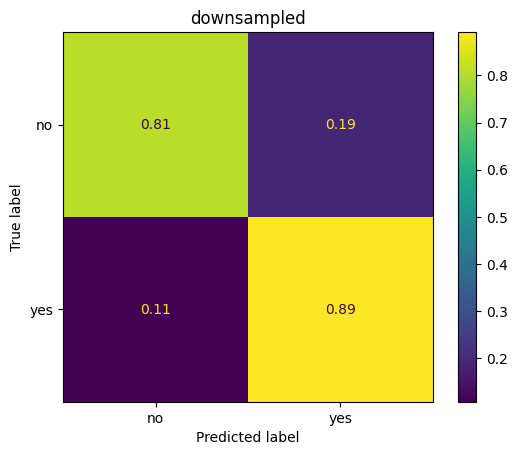

Acc 0.8191971690810572
f1 0.5434236246858419
precision 0.39076305220883534


In [11]:
exp_svc('rbf')

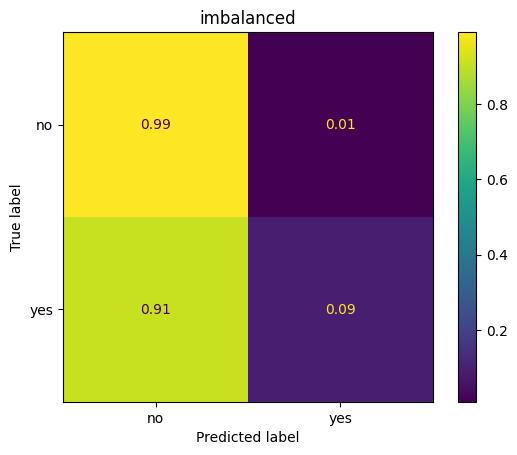

Acc 0.8823399314386818
f1 0.15822784810126583
precision 0.5780346820809249


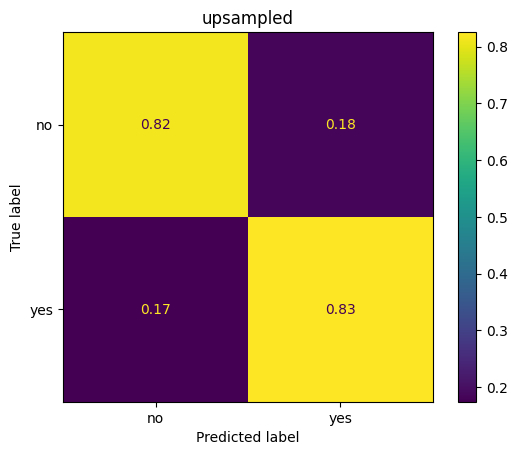

Acc 0.8167643481145638
f1 0.5209598149754264
precision 0.38048986486486486


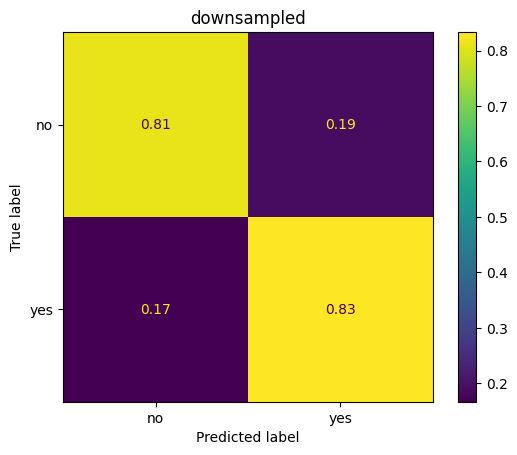

Acc 0.8144421099192746
f1 0.5200228832951945
precision 0.377962577962578


In [12]:
exp_svc('linear')

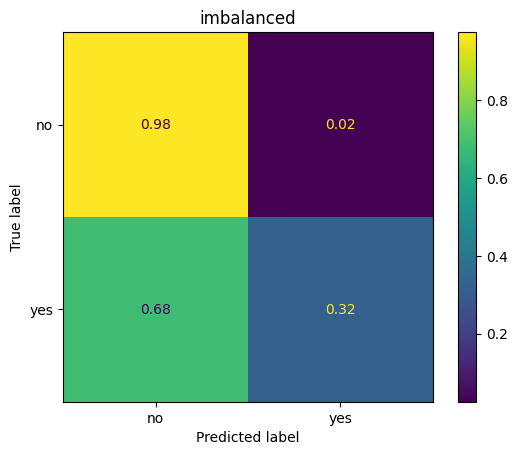

Acc 0.8958310295255999
f1 0.4227941176470588
precision 0.6377079482439926


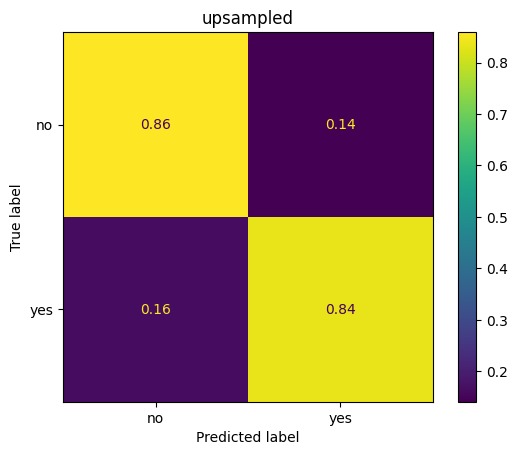

Acc 0.8562423974344797
f1 0.5838668373879642
precision 0.4485981308411215


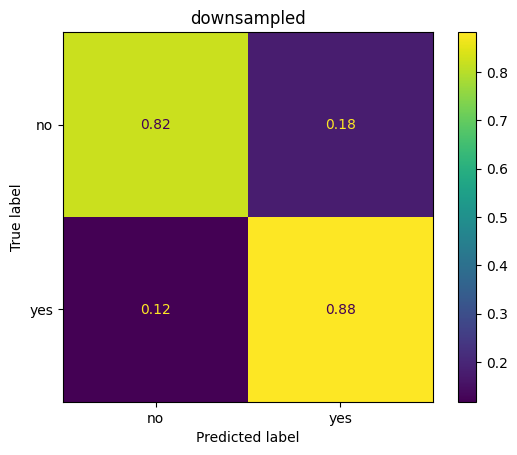

Acc 0.8279332080061926
f1 0.553130384836301
precision 0.4027603513174404


In [13]:
exp_svc('poly')

# MLP

In [14]:
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train.values)
X_train_t = X_train_t.to(dtype=torch.float32)
y_train_t = y_train_t.to(torch.int64)


X_train_up = torch.tensor(X_train_up)
y_train_up = torch.tensor(y_train_up.values)
X_train_up = X_train_up.to(dtype=torch.float32)
y_train_up = y_train_up.to(torch.int64)


X_train_down = torch.tensor(X_train_down)
y_train_down = torch.tensor(y_train_down.values)
X_train_down = X_train_down.to(dtype=torch.float32)
y_train_down = y_train_down.to(torch.int64)

X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test.values)
X_test_t = X_test_t.to(dtype=torch.float32)
y_test_t = y_test_t.to(torch.int64)

In [15]:
# Define your PyTorch model
class StockClassifier(nn.Module):
    def __init__(self, input_dim,num_classes,dropout=0.5):
        super(StockClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        X = self.dropout(x)
        x = self.fc3(x)
        return x

# Create an instance of your custom neural network
mymodel = StockClassifier(47,2)

# Actual data

In [16]:
# Create an instance of the neural network classifier
net = NeuralNetClassifier(
    module=mymodel,
    optimizer__momentum=0.95,
    module__input_dim=X_train.shape[1],  # Input dimension
    module__num_classes=2,  # Number of output classes
    criterion=nn.CrossEntropyLoss,  # Loss function
    optimizer=optim.SGD,  # Optimizer
    optimizer__lr=0.01,  # Learning rate
    optimizer__weight_decay=1e-5,  # L2 regularization
    max_epochs=50,  # Maximum number of training epochs
    batch_size=128,  # Batch size for training
    iterator_train__shuffle=True,  # Shuffle training data
    callbacks=[EarlyStopping(patience=3)]  # Early stopping callback
)

# Define hyperparameters to tune
params = {
    'optimizer__momentum': [0.5, 0.9,.999],
    'optimizer__weight_decay': [1e-4, 1e-5],
}

# Perform grid search with cross-validation
gs = GridSearchCV(net, params, cv=3, scoring='accuracy', verbose=1,n_jobs=-1)
gs.fit(X_train_t, y_train_t)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3349       0.8839        0.2594  1.3730
      2        0.2597       0.8889        0.2388  1.6934
      3        0.2481       0.8900        0.2330  1.1984
      4        0.2426       0.8902        0.2298  1.1372
      5        0.2378       0.8916        0.2286  1.1508
      6        0.2345       0.8923        0.2244  1.1938
      7        0.2323       0.8934        0.2234  1.2159
      8        0.2295       0.8944        0.2213  1.1881
      9        0.2297       0.8948        0.2203  1.1608
     10        0.2269       0.8949        0.2188  1.1972
     11        0.2257       0.8940        0.2203  1.2060
     12        0.2250       0.8944        0.2180  1.1422
     13        0.2239       0.8963        0.2166  1.1469
     14        0.2226       0.8938        0.2157  1.1470
     15        0.2227       

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=StockClassifier(
    (fc1): Linear(in_features=47, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  ),
  module__input_dim=47,
  module__num_classes=2,
),
             n_jobs=-1,
             param_grid={'optimizer__momentum': [0.5, 0.9, 0.999],
                         'optimizer__weight_decay': [0.0001, 1e-05]},
             scoring='accuracy', verbose=1)

Best parameters: {'optimizer__momentum': 0.9, 'optimizer__weight_decay': 1e-05}
Acc 0.9024659957978547
f1 0.5629335976214074
precision 0.6127292340884574


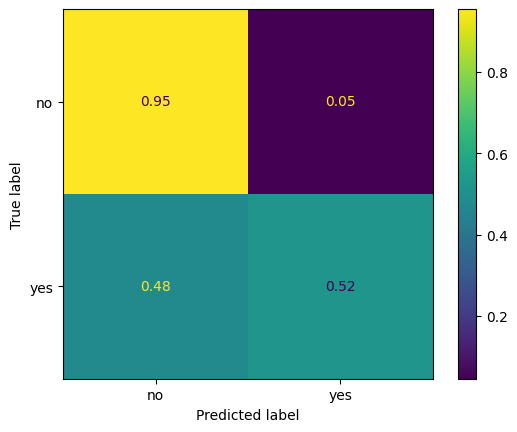

In [17]:
# Evaluate the model
gs.best_estimator_.save_params(f_params='saved_model/best_model_params.pkl',
                               f_optimizer='saved_model/best_optimizer_params.pkl',
                               f_history='saved_model/best_history.json',
                               f_pickle='saved_model/best_model.pkl')

print("Best parameters:", gs.best_params_)
best_model = gs.best_estimator_
pred = best_model.predict(X_test_t)
get_result(y_test_t,pred)

cm = confusion_matrix(y_test, pred, labels=best_model.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.show()

# Up sampled

In [18]:
gs.fit(X_train_up, y_train_up)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4738       0.8381        0.3851  1.9888
      2        0.3767       0.8498        0.3606  2.0436
      3        0.3553       0.8562        0.3472  2.0664
      4        0.3425       0.8604        0.3421  2.3493
      5        0.3342       0.8652        0.3331  2.0861
      6        0.3302       0.8662        0.3311  2.0577
      7        0.3248       0.8677        0.3248  2.0695
      8        0.3196       0.8693        0.3202  2.0451
      9        0.3185       0.8700        0.3184  2.0867
     10        0.3156       0.8725        0.3168  2.0442
     11        0.3120       0.8738        0.3126  2.0760
     12        0.3089       0.8721        0.3140  2.0548
     13        0.3071       0.8740        0.3112  2.2308
     14        0.3043       0.8746        0.3129  2.0645
     15        0.3029       

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=StockClassifier(
    (fc1): Linear(in_features=47, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  ),
  module__input_dim=47,
  module__num_classes=2,
),
             n_jobs=-1,
             param_grid={'optimizer__momentum': [0.5, 0.9, 0.999],
                         'optimizer__weight_decay': [0.0001, 1e-05]},
             scoring='accuracy', verbose=1)

Best parameters: {'optimizer__momentum': 0.9, 'optimizer__weight_decay': 1e-05}
Acc 0.8472851929669357
f1 0.5754687980325853
precision 0.43293246993524515


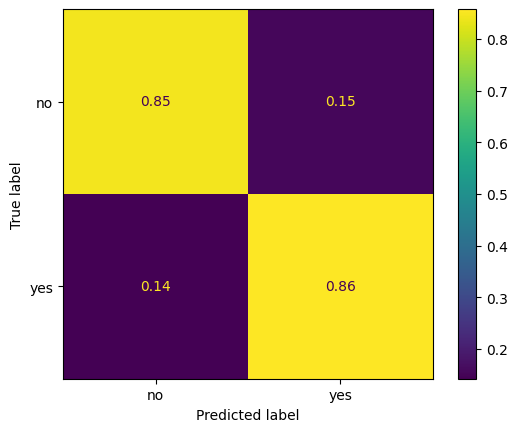

In [19]:
# Evaluate the model
gs.best_estimator_.save_params(f_params='saved_model/up_best_model_params.pkl',
                               f_optimizer='saved_model/up_best_optimizer_params.pkl',
                               f_history='saved_model/up_best_history.json',
                               f_pickle='saved_model/up_best_model.pkl')

print("Best parameters:", gs.best_params_)
best_model = gs.best_estimator_
pred = best_model.predict(X_test_t)
get_result(y_test_t,pred)
cm = confusion_matrix(y_test, pred, labels=best_model.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.show()

# down sampled

In [20]:
# Train the model
gs.fit(X_train_down, y_train_down)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6722       0.7685        0.6260  0.2465
      2        0.5695       0.8155        0.4740  0.2569
      3        0.4846       0.8214        0.4272  0.2650
      4        0.4589       0.8238        0.4134  0.2758
      5        0.4421       0.8268        0.4032  0.2692
      6        0.4312       0.8345        0.3969  0.2657
      7        0.4217       0.8369        0.3916  0.2661
      8        0.4149       0.8411        0.3872  0.2660
      9        0.4060       0.8405        0.3841  0.2605
     10        0.4056       0.8405        0.3832  0.2752
     11        0.4025       0.8405        0.3822  0.2724
     12        0.4000       0.8387        0.3810  0.2642
     13        0.3922       0.8405        0.3759  0.2655
     14        0.3905       0.8423        0.3756  0.2752
     15        0.3878       

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=StockClassifier(
    (fc1): Linear(in_features=47, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  ),
  module__input_dim=47,
  module__num_classes=2,
),
             n_jobs=-1,
             param_grid={'optimizer__momentum': [0.5, 0.9, 0.999],
                         'optimizer__weight_decay': [0.0001, 1e-05]},
             scoring='accuracy', verbose=1)

Best parameters: {'optimizer__momentum': 0.9, 'optimizer__weight_decay': 0.0001}
Acc 0.8347893398208559
f1 0.5592920353982301
precision 0.41235319704219225


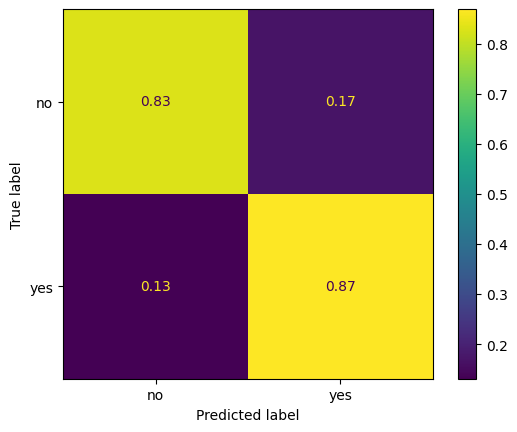

In [21]:
# Evaluate the model
gs.best_estimator_.save_params(f_params='saved_model/down_best_model_params.pkl',
                               f_optimizer='saved_model/down_best_optimizer_params.pkl',
                               f_history='saved_model/down_best_history.json',
                               f_pickle='saved_model/down_best_model.pkl')

print("Best parameters:", gs.best_params_)
best_model = gs.best_estimator_
pred = best_model.predict(X_test_t)
get_result(y_test_t,pred)

cm = confusion_matrix(y_test, pred, labels=best_model.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.show()

# Testing Steps

# SVM Testing on best saved model

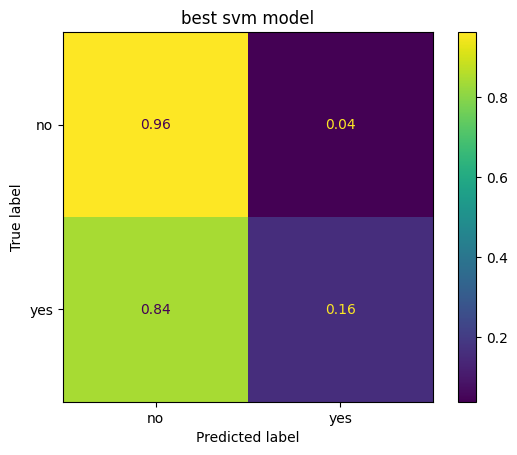

Acc 0.8650890191308194
f1 0.2229299363057325
precision 0.3653444676409186


In [22]:
best_svm_model = 'saved_model/SVM_upsampled_rbf.pkl'

test = pd.read_csv('dataset/test.csv',sep=',')
test.drop('poutcome',axis=1,inplace=True)
Xtest = test.drop('y',axis=1)
ytest = test['y']
ytest = ytest.replace(['yes','no'],[1,0])
# load preprocessor
loaded_preprocessor = joblib.load("saved_model/preprocessor.pkl")
Xtest = loaded_preprocessor.transform(Xtest)

# load model
clf = joblib.load(f"{best_svm_model}")

pred_svc = clf.predict(Xtest)
cm = confusion_matrix(ytest, pred_svc, labels=clf.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.title('best svm model')
plt.show()
get_result(ytest,pred_svc)

# MLP Testing on best saved model

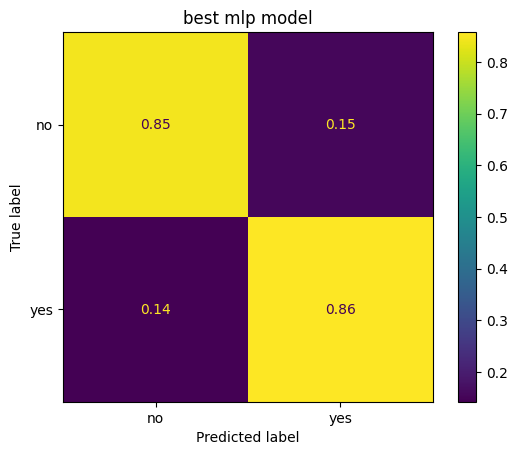

Acc 0.8472851929669357
f1 0.5754687980325853
precision 0.43293246993524515


In [23]:
# Define your PyTorch model
class StockClassifier(nn.Module):
    def __init__(self, input_dim,num_classes,dropout=0.5):
        super(StockClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        X = self.dropout(x)
        x = self.fc3(x)
        return x

Mymodel = StockClassifier(47,2)

best_mlp_model = NeuralNetClassifier(module=Mymodel)
best_mlp_model.initialize()
best_mlp_model.load_params(f_params='saved_model/up_best_model_params.pkl',
                    f_optimizer='saved_model/up_best_optimizer_params.pkl', 
                    f_history='saved_model/up_best_history.json', 
                    f_pickle='saved_model/up_best_model.pkl')


test = pd.read_csv('dataset/test.csv',sep=',')
test.drop('poutcome',axis=1,inplace=True)
Xtest = test.drop('y',axis=1)
ytest = test['y']
ytest = ytest.replace(['yes','no'],[1,0])
# load preprocessor
loaded_preprocessor = joblib.load("saved_model/preprocessor.pkl")
Xtest = loaded_preprocessor.transform(Xtest)

X_test_tensor = torch.tensor(Xtest)
y_test_tensor = torch.tensor(ytest.values)
X_test_tensor = X_test_tensor.to(dtype=torch.float32)
y_test_tensor = y_test_tensor.to(torch.int64)

pred_mlp = best_mlp_model.predict(X_test_tensor)
cm = confusion_matrix(ytest, pred_mlp, labels=[0,1])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.title('best mlp model')
plt.show()
get_result(y_test_tensor,pred_mlp)